In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pydicom import dcmread
from glob import glob

# Set style for better plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')

## 1. Lake Sediment Thickness Distribution

The sediment thickness was measured from CT scans of sediment cores recovered from the lake bed. Let's visualize the distribution of sediment thickness measurements.

In [2]:
# Load thickness distribution data
thickness = np.loadtxt('../data/cores/spectral_analysis/thickness_distribution.txt')

# Calculate statistics
mean_thickness = np.mean(thickness)
std_thickness = np.std(thickness)
median_thickness = np.median(thickness)

print(f"=== Lake Sediment Thickness Statistics ===")
print(f"Mean thickness: {mean_thickness:.2f} ± {std_thickness:.2f} mm")
print(f"Median thickness: {median_thickness:.2f} mm")
print(f"Range: {np.min(thickness):.2f} - {np.max(thickness):.2f} mm")
print(f"Number of measurements: {len(thickness)}")

=== Lake Sediment Thickness Statistics ===
Mean thickness: 132.90 ± 0.56 mm
Median thickness: 133.03 mm
Range: 131.98 - 134.08 mm
Number of measurements: 640


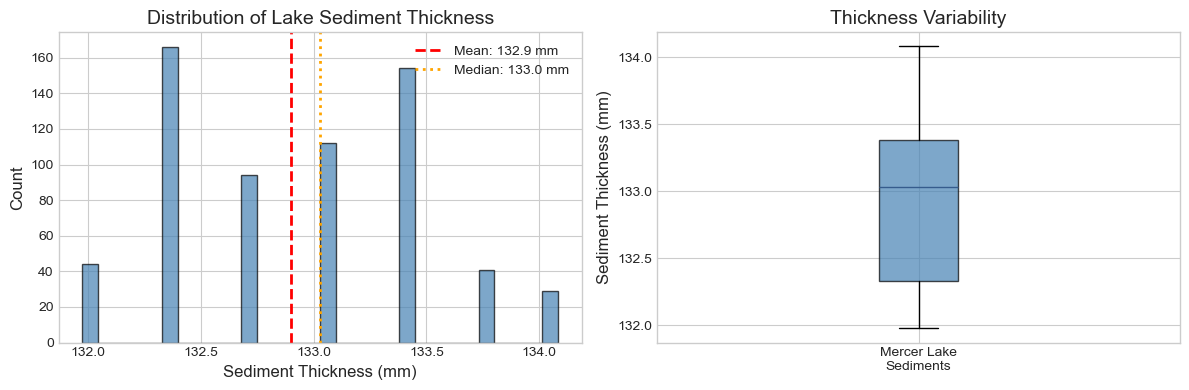

In [3]:
# Visualize the thickness distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram
axes[0].hist(thickness, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(mean_thickness, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_thickness:.1f} mm')
axes[0].axvline(median_thickness, color='orange', linestyle=':', linewidth=2, label=f'Median: {median_thickness:.1f} mm')
axes[0].set_xlabel('Sediment Thickness (mm)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Lake Sediment Thickness', fontsize=14)
axes[0].legend()

# Box plot
bp = axes[1].boxplot(thickness, vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('steelblue')
bp['boxes'][0].set_alpha(0.7)
axes[1].set_ylabel('Sediment Thickness (mm)', fontsize=12)
axes[1].set_title('Thickness Variability', fontsize=14)
axes[1].set_xticklabels(['Mercer Lake\nSediments'])

plt.tight_layout()
plt.show()

## 2. Sedimentation Rate Analysis

The spectral analysis of the sediment brightness traces reveals periodic variations that can be used to estimate sedimentation rates. These rates are crucial for determining the age of the lake.

In [17]:
# Load sedimentation rate data from spectral analysis
# The raw values are in 0.01 mm/yr units, so divide by 100 to get mm/yr
rates = pd.read_csv('../data/cores/spectral_analysis/rates_all.csv') / 100
freq = pd.read_csv('../data/cores/spectral_analysis/freq_all.csv')

print(f"Sedimentation rate data shape: {rates.shape}")
print(f"Frequency data shape: {freq.shape}")
print(f"Rate range: {rates.values.min():.3f} - {rates.values.max():.3f} mm/yr")

Sedimentation rate data shape: (23571, 164)
Frequency data shape: (11860, 164)
Rate range: nan - nan mm/yr


In [18]:
# Analyze the distribution of sedimentation rates
# Flatten the rates array and remove NaN values
rates_flat = rates.values.flatten()
rates_clean = rates_flat[~np.isnan(rates_flat)]
rates_clean = rates_clean[rates_clean > 0]  # Keep only positive rates

print(f"=== Sedimentation Rate Statistics ===")
print(f"Number of estimates: {len(rates_clean):,}")
print(f"Mean rate: {np.mean(rates_clean):.3f} mm/yr")
print(f"Median rate: {np.median(rates_clean):.3f} mm/yr")
print(f"Range: {np.min(rates_clean):.3f} - {np.max(rates_clean):.3f} mm/yr")
print(f"Std dev: {np.std(rates_clean):.3f} mm/yr")

=== Sedimentation Rate Statistics ===
Number of estimates: 859,628
Mean rate: 1.119 mm/yr
Median rate: 0.842 mm/yr
Range: 0.276 - 2.500 mm/yr
Std dev: 0.662 mm/yr


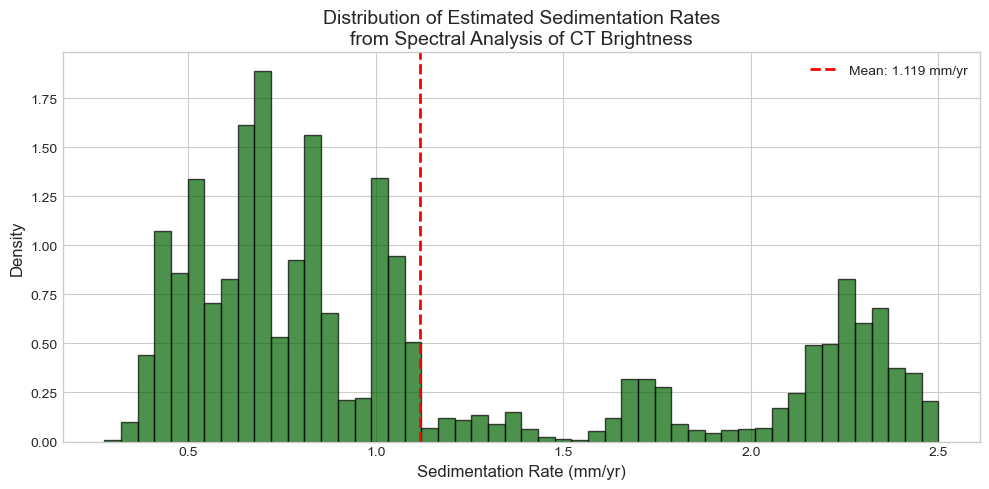

In [19]:
# Visualize sedimentation rates
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(rates_clean, bins=50, edgecolor='black', alpha=0.7, color='darkgreen', density=True)
ax.axvline(np.mean(rates_clean), color='red', linestyle='--', linewidth=2, 
           label=f'Mean: {np.mean(rates_clean):.3f} mm/yr')
ax.set_xlabel('Sedimentation Rate (mm/yr)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Distribution of Estimated Sedimentation Rates\nfrom Spectral Analysis of CT Brightness', fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()

## 3. Estimating Lake Age

Using the sediment thickness and sedimentation rates, we can estimate the age of Mercer Subglacial Lake. This gives us insight into when the lake formed under the ice sheet.

In [20]:
# Estimate lake age using Monte Carlo approach
n_samples = 10000

# Sample from thickness distribution
thickness_samples = np.random.choice(thickness, size=n_samples, replace=True)

# Sample from sedimentation rate distribution
rate_samples = np.random.choice(rates_clean, size=n_samples, replace=True)

# Calculate age: thickness / rate
age_samples = thickness_samples / rate_samples  # in years

# Filter reasonable ages (< 100,000 years)
age_samples = age_samples[age_samples < 100000]

print(f"=== Estimated Lake Age ===")
print(f"Mean age: {np.mean(age_samples):.0f} years")
print(f"Median age: {np.median(age_samples):.0f} years")
print(f"95% CI: {np.percentile(age_samples, 2.5):.0f} - {np.percentile(age_samples, 97.5):.0f} years")

=== Estimated Lake Age ===
Mean age: 160 years
Median age: 157 years
95% CI: 55 - 320 years


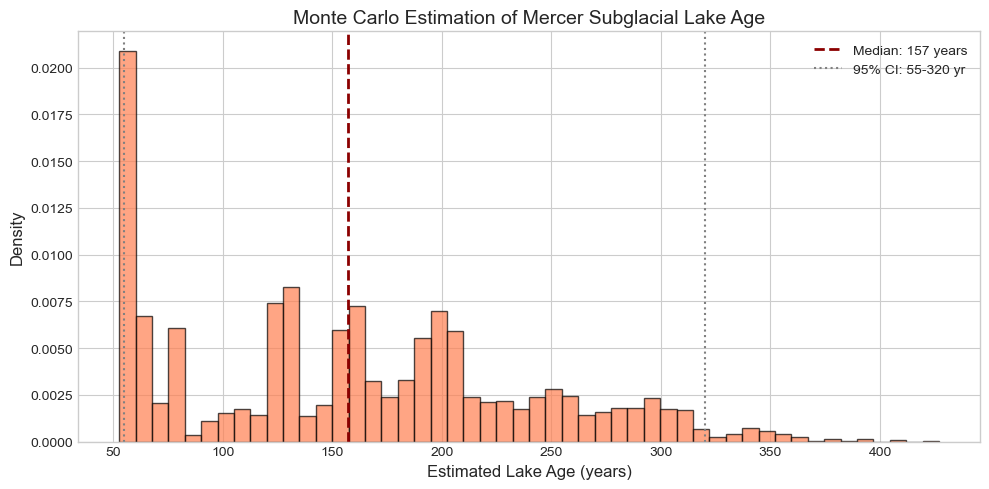

In [21]:
# Visualize age distribution
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(age_samples, bins=50, edgecolor='black', alpha=0.7, color='coral', density=True)
ax.axvline(np.median(age_samples), color='darkred', linestyle='--', linewidth=2, 
           label=f'Median: {np.median(age_samples):.0f} years')
ax.axvline(np.percentile(age_samples, 2.5), color='gray', linestyle=':', linewidth=1.5)
ax.axvline(np.percentile(age_samples, 97.5), color='gray', linestyle=':', linewidth=1.5,
           label=f'95% CI: {np.percentile(age_samples, 2.5):.0f}-{np.percentile(age_samples, 97.5):.0f} yr')

ax.set_xlabel('Estimated Lake Age (years)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
ax.set_title('Monte Carlo Estimation of Mercer Subglacial Lake Age', fontsize=14)
ax.legend()

plt.tight_layout()
plt.show()

## 4. CT Scan Visualization - Sediment Core Structure

Let's look at the actual CT scan data to see the laminated sediment structure that was used for all these analyses.

In [9]:
# Load CT scan data from one of the cores
files = glob('../data/cores/01UW-C/IM*')

# Load a subset of slices
slices = []
for f in files[:10]:  # Just load first 10 for quick visualization
    ds = dcmread(f)
    if isinstance(ds.SliceLocation, float):
        slices.append(ds)

slices = sorted(slices, key=lambda s: s.SliceLocation)
print(f"Loaded {len(slices)} CT slices")

Loaded 10 CT slices


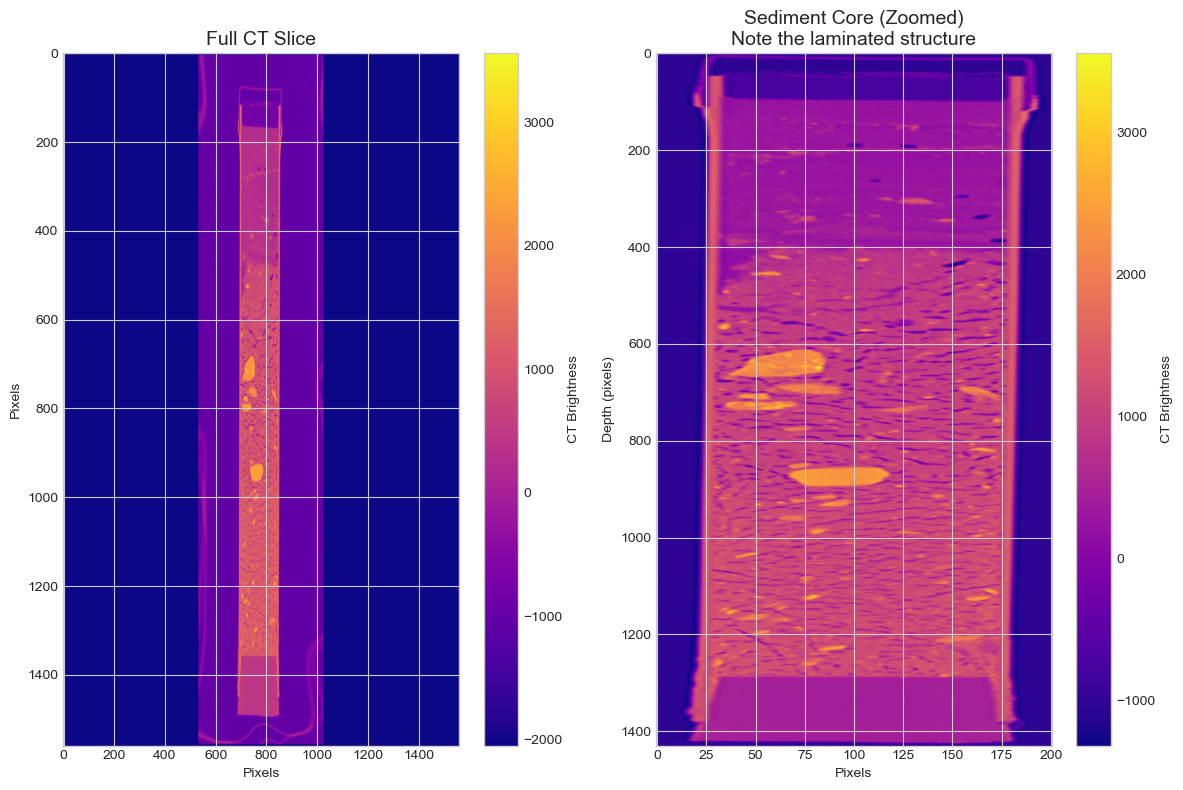

In [10]:
# Visualize a single CT slice
if len(slices) > 0:
    # Get pixel spacing
    ps = slices[0].PixelSpacing
    
    # Get the middle slice
    mid_idx = len(slices) // 2
    img = slices[mid_idx].pixel_array
    
    # Subset to the core region
    core_img = img[70:1500, 670:871]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 8))
    
    # Full slice
    im1 = axes[0].imshow(img, cmap='plasma', aspect='auto')
    axes[0].set_title('Full CT Slice', fontsize=14)
    axes[0].set_xlabel('Pixels')
    axes[0].set_ylabel('Pixels')
    plt.colorbar(im1, ax=axes[0], label='CT Brightness')
    
    # Core region (zoomed)
    im2 = axes[1].imshow(core_img, cmap='plasma', aspect='auto')
    axes[1].set_title('Sediment Core (Zoomed)\nNote the laminated structure', fontsize=14)
    axes[1].set_xlabel('Pixels')
    axes[1].set_ylabel('Depth (pixels)')
    plt.colorbar(im2, ax=axes[1], label='CT Brightness')
    
    plt.tight_layout()
    plt.show()
else:
    print("No CT slices loaded")

## 5. Brightness Profile Analysis

The vertical brightness profiles through the sediments show the laminated structure. Variations in brightness indicate changes in sediment composition over time.

In [11]:
# Load filtered brightness traces
traces = pd.read_csv('../data/cores/spectral_analysis/core_traces_filtered.csv', header=None, index_col=0)

print(f"Loaded {traces.shape[1]} brightness traces")
print(f"Depth range: 0 - {traces.index.max():.1f} mm")

Loaded 164 brightness traces
Depth range: 0 - 99.7 mm


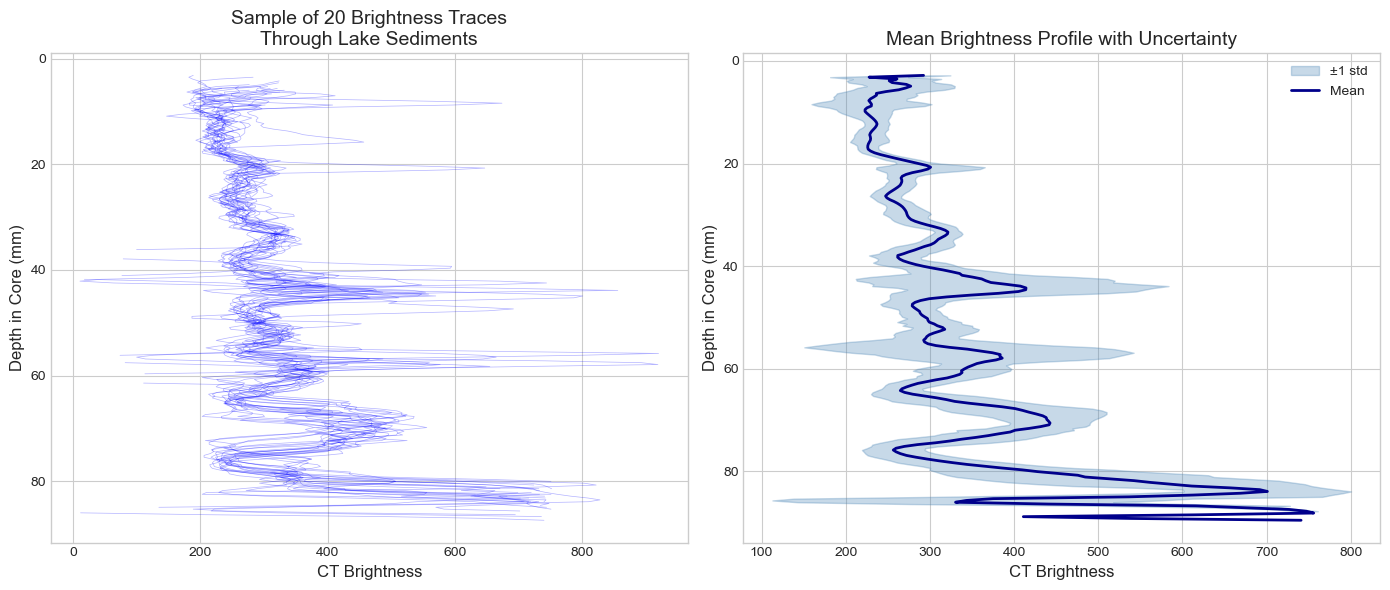

In [12]:
# Plot a selection of brightness traces
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot multiple traces
n_traces_to_plot = 20
trace_indices = np.linspace(0, traces.shape[1]-1, n_traces_to_plot, dtype=int)

for i, idx in enumerate(trace_indices):
    axes[0].plot(traces.iloc[:, idx].values, traces.index.values, 
                 alpha=0.3, linewidth=0.5, color='blue')

axes[0].invert_yaxis()
axes[0].set_xlabel('CT Brightness', fontsize=12)
axes[0].set_ylabel('Depth in Core (mm)', fontsize=12)
axes[0].set_title(f'Sample of {n_traces_to_plot} Brightness Traces\nThrough Lake Sediments', fontsize=14)

# Plot mean trace with uncertainty
mean_trace = traces.mean(axis=1)
std_trace = traces.std(axis=1)

axes[1].fill_betweenx(traces.index.values, 
                      mean_trace - std_trace, 
                      mean_trace + std_trace, 
                      alpha=0.3, color='steelblue', label='±1 std')
axes[1].plot(mean_trace, traces.index.values, color='darkblue', linewidth=2, label='Mean')
axes[1].invert_yaxis()
axes[1].set_xlabel('CT Brightness', fontsize=12)
axes[1].set_ylabel('Depth in Core (mm)', fontsize=12)
axes[1].set_title('Mean Brightness Profile with Uncertainty', fontsize=14)
axes[1].legend()

plt.tight_layout()
plt.show()

## 6. Summary of Key Findings

This analysis of Mercer Subglacial Lake sediments reveals:

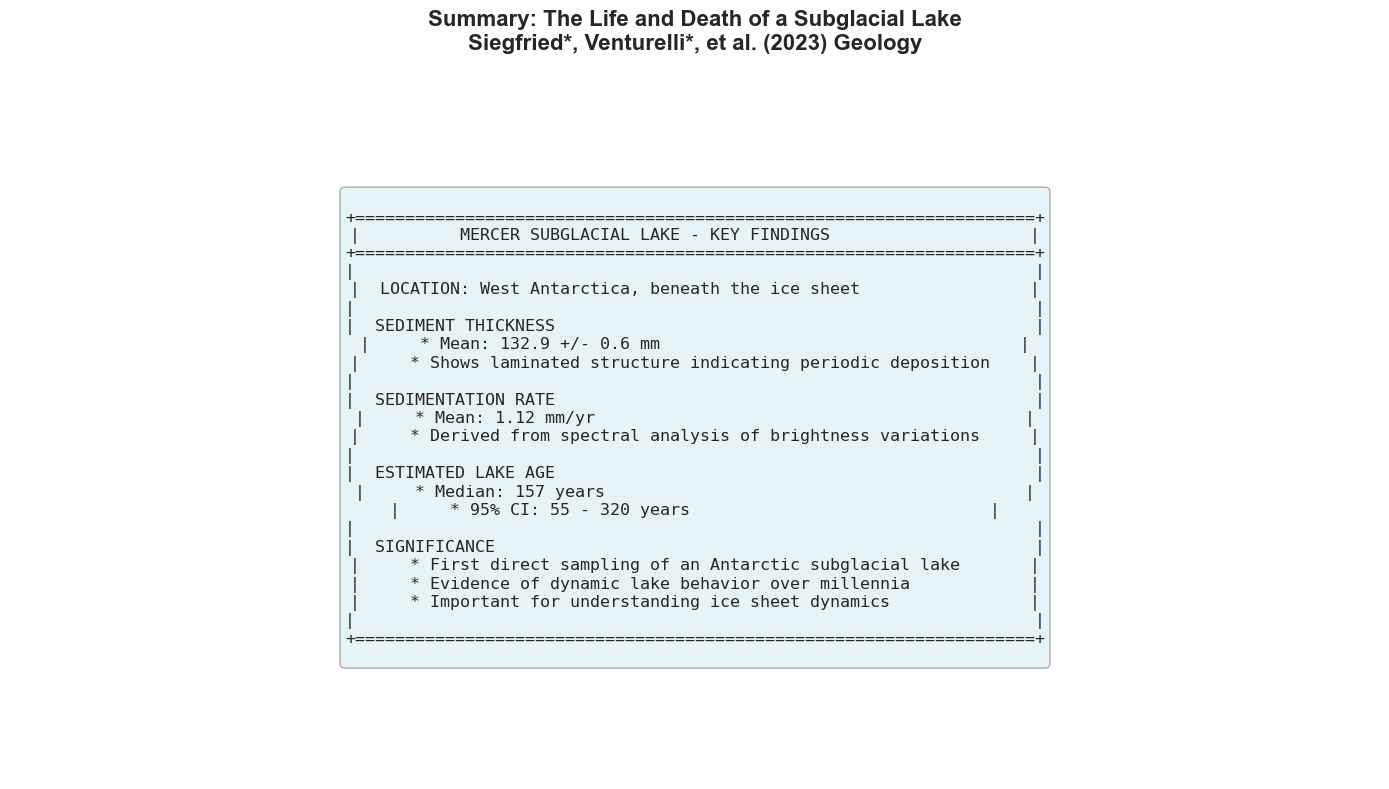

In [23]:
# Create a summary visualization
fig = plt.figure(figsize=(14, 8))

# Create text summary
summary_text = f"""
+====================================================================+
|          MERCER SUBGLACIAL LAKE - KEY FINDINGS                    |
+====================================================================+
|                                                                    |
|  LOCATION: West Antarctica, beneath the ice sheet                 |
|                                                                    |
|  SEDIMENT THICKNESS                                                |
|     * Mean: {mean_thickness:.1f} +/- {std_thickness:.1f} mm                                    |
|     * Shows laminated structure indicating periodic deposition    |
|                                                                    |
|  SEDIMENTATION RATE                                                |
|     * Mean: {np.mean(rates_clean):.2f} mm/yr                                           |
|     * Derived from spectral analysis of brightness variations     |
|                                                                    |
|  ESTIMATED LAKE AGE                                                |
|     * Median: {np.median(age_samples):.0f} years                                          |
|     * 95% CI: {np.percentile(age_samples, 2.5):.0f} - {np.percentile(age_samples, 97.5):.0f} years                              |
|                                                                    |
|  SIGNIFICANCE                                                      |
|     * First direct sampling of an Antarctic subglacial lake       |
|     * Evidence of dynamic lake behavior over millennia            |
|     * Important for understanding ice sheet dynamics              |
|                                                                    |
+====================================================================+
"""

plt.text(0.5, 0.5, summary_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='center', horizontalalignment='center',
         fontfamily='monospace', 
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

plt.axis('off')
plt.title('Summary: The Life and Death of a Subglacial Lake\nSiegfried*, Venturelli*, et al. (2023) Geology', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

---

## References

**Publication:**
> Siegfried, M. R., Venturelli, R. A., Patterson, M. O., et al. (2023). The life and death of a subglacial lake in West Antarctica. *Geology*. https://doi.org/10.1130/G50995.1

**Data:**
> Siegfried, M. R., et al. (2023). Data for Siegfried*, Venturelli*, et al., 2023, Geology. *Zenodo*. https://doi.org/10.5281/ZENODO.7597019